---
author: Chia-Wei Hsu, Harsha R. Hampapura
title: Global Mean Temperature from JRA-3Q
---

## Calculate Global Mean of Surface Temperatures from JRA-3Q reanalysis dataset hosted on NCAR's GDEX

In [18]:
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import xarray as xr
import intake
import intake_esm
import pandas as pd
import os

In [2]:
# Set up your sratch folder path
username       = os.environ["USER"]
glade_scratch  = "/glade/derecho/scratch/" + username
print(glade_scratch)
#
# jra3q_catalog_url = 'https://osdf-director.osg-htc.org/ncar/gdex/d640000/catalogs/d640000-osdf.json'
jra3q_catalog_url = 'https://osdf-director.osg-htc.org/ncar/gdex/d640000/catalogs/d640000-https.json'

/glade/derecho/scratch/harshah


In [3]:
# GMST function ###
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [4]:
USE_PBS_SCHEDULER = True

In [5]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = glade_scratch + '/dask/spill',
        log_directory = glade_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(6)
    return cluster

In [6]:
# Obtain dask cluster in one of three ways
if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

/glade/u/home/harshah/.conda/envs/osdf/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34541 instead
  warnings.warn(


In [7]:
# Scale the cluster and display cluster dashboard URL
n_workers =5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(9279d465, 'tcp://128.117.208.116:44293', workers=5, threads=5, memory=20.00 GiB)

In [8]:
jra3q_cat = intake.open_esm_datastore(jra3q_catalog_url)
jra3q_cat

,unique
path,33
variable,351
format,1
short_name,351
long_name,138
units,30
start_time,2
end_time,4
level,6
level_units,5


In [9]:
jra3q_cat.df.head()

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,https://data.gdex.ucar.edu/d640000/kerchunk/an...,bvf2-theta-an-gauss,reference,bvf2-theta-an-gauss,Square of Brunt-Vaisala frequency,s-2,1947-09-01 00:00:00,2025-09-30 18:00:00,air_potential_temperature,K,21600000000000 nanoseconds
1,https://data.gdex.ucar.edu/d640000/kerchunk/an...,hgt-theta-an-gauss,reference,hgt-theta-an-gauss,Geopotential height,gpm,1947-09-01 00:00:00,2025-09-30 18:00:00,air_potential_temperature,K,21600000000000 nanoseconds
2,https://data.gdex.ucar.edu/d640000/kerchunk/an...,mntsf-theta-an-gauss,reference,mntsf-theta-an-gauss,Montgomery stream function,m2 s-2,1947-09-01 00:00:00,2025-09-30 18:00:00,air_potential_temperature,K,21600000000000 nanoseconds
3,https://data.gdex.ucar.edu/d640000/kerchunk/an...,original_number_of_grid_points_per_latitude_ci...,reference,reduced longitudes,original number of grid points per latitude ci...,1,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
4,https://data.gdex.ucar.edu/d640000/kerchunk/an...,pres-theta-an-gauss,reference,pres-theta-an-gauss,Pressure,Pa,1947-09-01 00:00:00,2025-09-30 18:00:00,air_potential_temperature,K,21600000000000 nanoseconds


In [10]:
jra3q_unique_vars= jra3q_cat.df[['variable','long_name']].drop_duplicates()
jra3q_unique_vars

,variable,long_name
0,bvf2-theta-an-gauss,Square of Brunt-Vaisala frequency
1,hgt-theta-an-gauss,Geopotential height
2,mntsf-theta-an-gauss,Montgomery stream function
3,original_number_of_grid_points_per_latitude_ci...,original number of grid points per latitude ci...
4,pres-theta-an-gauss,Pressure
...,...,...
445,tmpmin2m-hgt-fc-gauss,2m minimum temperature
449,windmax-sfc-fc-gauss,Maximum surface wind speed
450,land-sfc-cn-gauss,"Land cover (0 = sea, 1 = land)"
454,vtype-sfc-cn-gauss,Type of vegetation (JMA code table 4.12)


In [11]:
jra3q_unique_vars[1:100]

,variable,long_name
1,hgt-theta-an-gauss,Geopotential height
2,mntsf-theta-an-gauss,Montgomery stream function
3,original_number_of_grid_points_per_latitude_ci...,original number of grid points per latitude ci...
4,pres-theta-an-gauss,Pressure
5,pvort-theta-an-gauss,Potential vorticity
...,...,...
124,ugrd10m-hgt-an-gauss,10m u-component of wind
127,vgrd10m-hgt-an-gauss,10m v-component of wind
128,weasd-sfc-an-gauss,Water equivalent of accumulated snow depth
130,depr2m-hgt-an-ll125,2m dewpoint depression (or deficit)


### Filter variables that start with temp

In [12]:
temp_cat = jra3q_cat.search(long_name='temp*')
temp_cat.df

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,https://data.gdex.ucar.edu/d640000/kerchunk/an...,soiltmp-bg-an-gauss,reference,soiltmp-bg-an-gauss,Soil temperature below ground,K,1947-09-01 00:00:00,2025-09-30 18:00:00,depth,m,21600000000000 nanoseconds
1,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tsc-sfc-an-gauss,reference,tsc-sfc-an-gauss,Canopy temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
2,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tsg-sfc-an-gauss,reference,tsg-sfc-an-gauss,Ground temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
3,https://data.gdex.ucar.edu/d640000/kerchunk/an...,soiltmp-bg-an-ll125,reference,soiltmp-bg-an-ll125,Soil temperature below ground,K,1947-09-01 00:00:00,2025-09-30 18:00:00,depth,m,21600000000000 nanoseconds
4,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tsc-sfc-an-ll125,reference,tsc-sfc-an-ll125,Canopy temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
5,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tsg-sfc-an-ll125,reference,tsg-sfc-an-ll125,Ground temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
6,https://data.gdex.ucar.edu/d640000/kerchunk/an...,pot-sfc-an-gauss,reference,pot-sfc-an-gauss,Potential temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
7,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tmp2m-hgt-an-gauss,reference,tmp2m-hgt-an-gauss,2m temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
8,https://data.gdex.ucar.edu/d640000/kerchunk/an...,pot-sfc-an-ll125,reference,pot-sfc-an-ll125,Potential temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
9,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tmp2m-hgt-an-ll125,reference,tmp2m-hgt-an-ll125,2m temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds


- Let us pick the 2m max air temperature and compute GMST
- Currently intake-esm does not support the kerchunk engine. So, let us download a PR that does 

In [13]:
jra3q_temps = jra3q_cat.search(variable='tmp2m-hgt-an-gauss')
jra3q_datasets = jra3q_temps.to_dataset_dict(xarray_open_kwargs={'engine':'kerchunk',"chunks": {}} )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


<div><progress max="1" value="1"></progress> 100.00% [1/1 00:08&lt;00:00]</div>

In [14]:
jra3q_datasets.keys()

dict_keys(['tmp2m-hgt-an-gauss.tmp2m-hgt-an-gauss'])

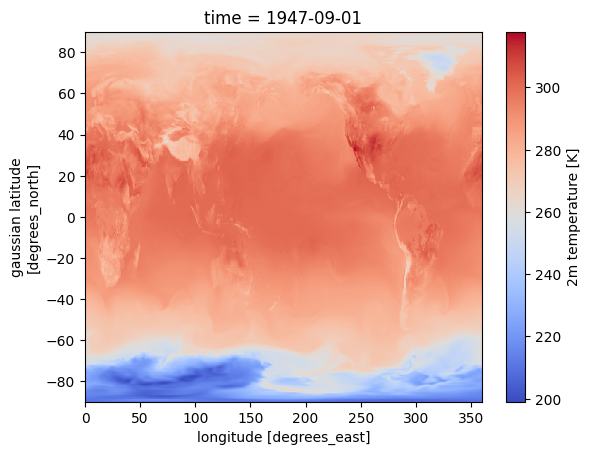

In [15]:
ds = jra3q_datasets['tmp2m-hgt-an-gauss.tmp2m-hgt-an-gauss']
ds['tmp2m-hgt-an-gauss'].isel(time=0).plot(cmap='coolwarm')

In [16]:
%%time 
# a quick calculation of global mean surface temperature hourly time series
da_tmp2m = ds['tmp2m-hgt-an-gauss'].sel(time=slice('2025-01-01','2025-09-25')).mean(dim=['lat','lon']).compute()

CPU times: user 1min 22s, sys: 4.25 s, total: 1min 27s
Wall time: 6min 40s


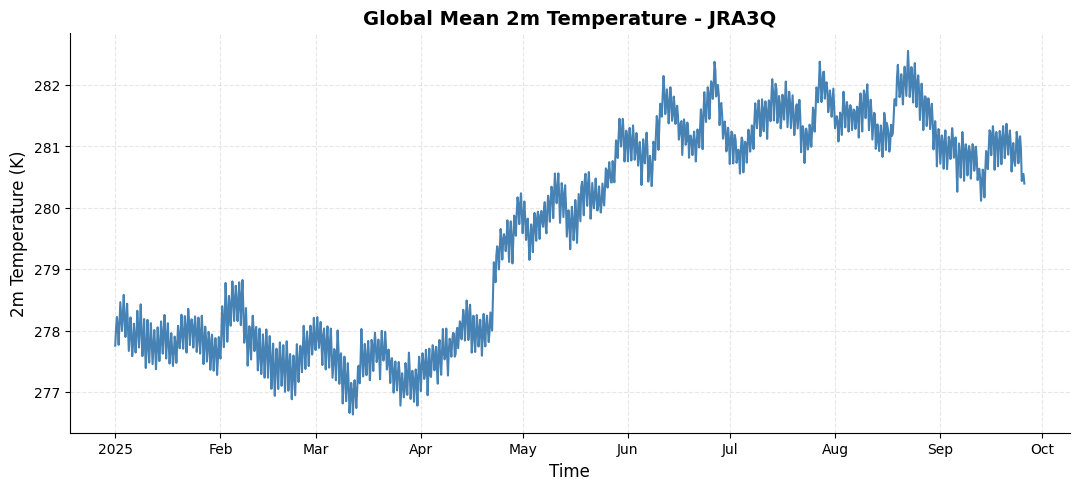

In [19]:
# Create a customized time series plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 1, 1])

# plot time series
da_tmp2m.plot(ax=ax, color='steelblue', linewidth=1.5)

# Customize the plot
ax.set_title('Global Mean 2m Temperature - JRA3Q', fontsize=14, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('2m Temperature (K)', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [20]:
cluster.close()